## Gather and scale Offensive Rating (ORtg), Defensive Rating (DRtg), and Net Rating (NRtg) for every team for every season 1998-2023

Import necessary packages

In [10]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import linregress

Prep URL for 1998-2023 seasons

In [4]:
YEARS = [y for y in range(1998, 2024)]
def make_link (year):
    return f"https://www.basketball-reference.com/leagues/NBA_{year}.html"

Scrape ORtg, DRtg, and NRtg Data for every team from 1998-2023 seasons

In [5]:
data = []

for year in YEARS:
    page = requests.get(make_link(year))
    time.sleep(2)
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find("table", {"id": "advanced-team"})
    if table:
        rows = table.find_all("tr")
        
        for row in rows[1:]:
            cells = row.find_all(["th", "td"])
            
            team = cells[1].text.strip()   # 'Team' column
            if team != "Team":
                ortg = cells[10].text.strip()  # 'ORtg' column
                drtg = cells[11].text.strip()  # 'DRtg' column
                nrtg = cells[12].text.strip()  # 'NRtg' column
                
                data.append((year, team, ortg, drtg, nrtg))




Scale all the values between 0 and 1 for each year for each column

In [6]:
data = pd.DataFrame(data, columns=["Year", "Team", "ORtg", "DRtg", "NRtg"])

# convert data from strings to floats
data['NRtg'] = data['NRtg'].str.replace('+', '').replace('', '0')
data[['ORtg', 'DRtg', 'NRtg']] = data[['ORtg', 'DRtg', 'NRtg']].astype(float)

# Initialize separate MinMaxScalers for each column
scalers = {
    'ORtg': MinMaxScaler(),
    'DRtg': MinMaxScaler(),
    'NRtg': MinMaxScaler()
}

grouped = data.groupby('Year')

# Scale the stats for each group (i.e., each year) and each column individually
scaled_dfs = []
for year, group in grouped:
    scaled_group = group.copy()
    for col in ['ORtg', 'DRtg', 'NRtg']:
        scaler = scalers[col]
        scaled_group[col] = scaler.fit_transform(group[[col]])
    scaled_dfs.append(scaled_group)

scaled_df = pd.concat(scaled_dfs)

Export data to csv

In [7]:
scaled_df.to_csv("rtg_data_scaled.csv", index=False)

Make and export a new dataframe with stats of just the NBA champions

In [8]:
# list of every champion team from 1998-2023
champions = ["Chicago Bulls*", "San Antonio Spurs*", "Los Angeles Lakers*", "Los Angeles Lakers*", 
             "Los Angeles Lakers*", "San Antonio Spurs*", "Detroit Pistons*", "San Antonio Spurs*", 
             "Miami Heat*", "San Antonio Spurs*", "Boston Celtics*", "Los Angeles Lakers*", 
             "Los Angeles Lakers*", "Dallas Mavericks*", "Miami Heat*", "Miami Heat*", "San Antonio Spurs*",
             "Golden State Warriors*", "Cleveland Cavaliers*", "Golden State Warriors*",
             "Golden State Warriors*", "Toronto Raptors*", "Los Angeles Lakers*", "Golden State Warriors",
             "Milwaukee Bucks*", "Denver Nuggets*"]

champion_df = pd.DataFrame()
champion_stats = []

for year, champion_team in enumerate(champions, start=1998):
    # Filter the 'scaled_df' for the champion team of the current year
    curr_year = scaled_df[scaled_df['Year'] == year]
    champion_stats = curr_year[curr_year['Team'] == champion_team]
    champion_df = pd.concat([champion_stats, champion_df])
    
champion_df.to_csv("champs.csv", index=False)

Make graphs of ratings over time

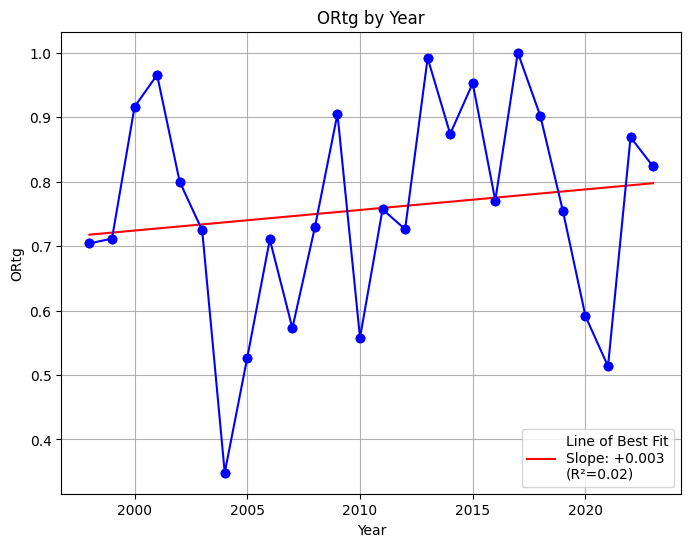

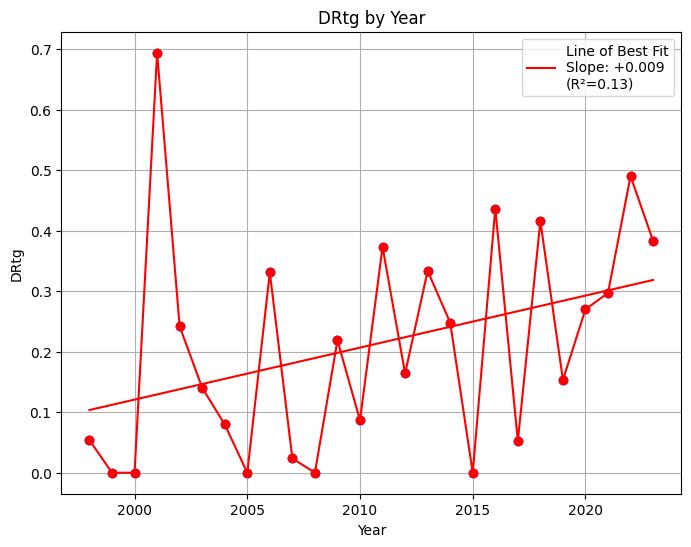

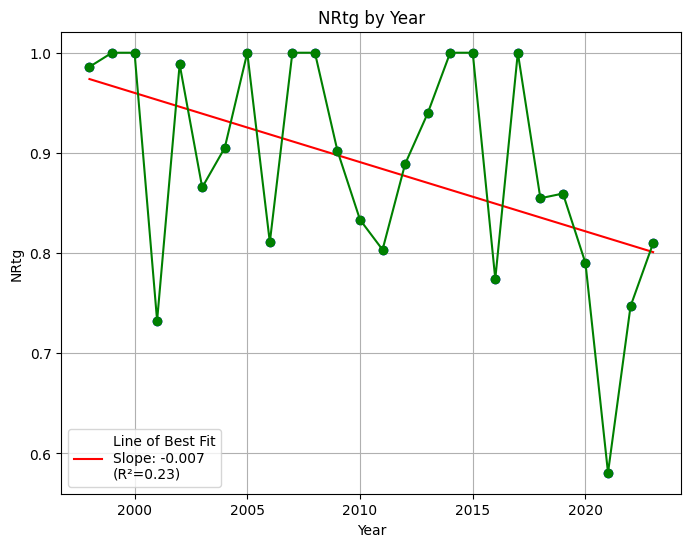

In [15]:
def format_slope(slope):
    if slope > 0:
        return f'+{slope:.3f}'
    else:
        return f'{slope:.3f}'

# Plot 'ORtg' by 'Year'
plt.figure(figsize=(8, 6))
plt.scatter(champion_df['Year'], champion_df['ORtg'], color='blue')
slope, intercept, r_value, p_value, std_err = linregress(champion_df['Year'], champion_df['ORtg'])
line = slope * champion_df['Year'] + intercept
plt.plot(champion_df['Year'], line, color='red', label=f'Line of Best Fit\nSlope: {format_slope(slope)}\n(R²={r_value**2:.2f})')
plt.plot(champion_df['Year'], champion_df['ORtg'], marker='o', color='blue', linestyle='-')
plt.title('ORtg by Year')
plt.xlabel('Year')
plt.ylabel('ORtg')
plt.legend()
plt.grid(True)
plt.show()

# Plot 'DRtg' by 'Year'
plt.figure(figsize=(8, 6))
plt.scatter(champion_df['Year'], champion_df['DRtg'], color='blue')
slope, intercept, r_value, p_value, std_err = linregress(champion_df['Year'], champion_df['DRtg'])
line = slope * champion_df['Year'] + intercept
plt.plot(champion_df['Year'], line, color='red', label=f'Line of Best Fit\nSlope: {format_slope(slope)}\n(R²={r_value**2:.2f})')
plt.plot(champion_df['Year'], champion_df['DRtg'], marker='o', color='red', linestyle='-')
plt.title('DRtg by Year')
plt.xlabel('Year')
plt.ylabel('DRtg')
plt.legend()
plt.grid(True)
plt.show()

# Plot 'NRtg' by 'Year'
plt.figure(figsize=(8, 6))
plt.scatter(champion_df['Year'], champion_df['NRtg'], color='blue')
slope, intercept, r_value, p_value, std_err = linregress(champion_df['Year'], champion_df['NRtg'])
line = slope * champion_df['Year'] + intercept
plt.plot(champion_df['Year'], line, color='red', label=f'Line of Best Fit\nSlope: {format_slope(slope)}\n(R²={r_value**2:.2f})')
plt.plot(champion_df['Year'], champion_df['NRtg'], marker='o', color='green', linestyle='-')
plt.title('NRtg by Year')
plt.xlabel('Year')
plt.ylabel('NRtg')
plt.legend()
plt.grid(True)
plt.show()